In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].bbmean()), inplace=True)
    
    return data

In [5]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1.values)
        for feature in self.features:
            X.append(self.test[feature].values[forvard_time])
        return X
    
    def get_y(self, forward_time):
        y = self.test.P1.values[forward_time]
        return y
    
    def add_feature(self, feature_name):
        self.train.append(feature_value)
        
        

In [6]:
def prepare_data(data):
    data['P1'] = data.P1.interpolate()
    data['pressure'] = data.pressure.interpolate()
    data['humidity'] = data.humidity.interpolate()
    data['temperature'] = data.temperature.interpolate()
    return data

In [7]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [8]:
sel_columns = ['P1', 'pressure', 'temperature', 'humidity', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time']
data = data[sel_columns]

In [9]:
data = prepare_data(data)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108001 entries, 2019-04-01 00:00:00+00:00 to 2020-04-10 00:00:00+00:00
Data columns (total 8 columns):
P1                108001 non-null float64
pressure          108001 non-null float64
temperature       108001 non-null float64
humidity          108001 non-null float64
wind_direction    108001 non-null object
wind_speed        108001 non-null int64
prec_amount       52920 non-null object
prec_time         52920 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 7.4+ MB


In [11]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [12]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [13]:
chunk_len = 48
test_len = 24
start_idx = data.index[0]
end_idx = data.index[-1] - datetime.timedelta(hours=chunk_len)
num_samples = 1700

chunks = generate_chunks(data.resample('1H').mean(), num_samples,
                         start_idx, end_idx,
                         chunk_len, test_len,
                         []
                        )

In [14]:
train, test = train_test_split(chunks, test_size=0.3, random_state=42)

In [15]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [16]:
def get_mae(models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [17]:
mod = Lasso(alpha=0.2)
models = train_models(mod, train, test_len)

In [18]:
mae = get_mae(models, test)

In [19]:
mod1 = RandomForestRegressor(min_samples_leaf=3, random_state=42)
models1 = train_models(mod1, train, test_len)

In [20]:
mae1= get_mae(models1, test)

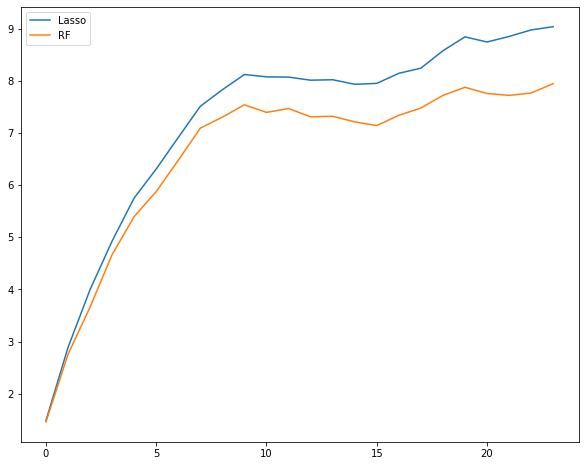

In [21]:
plt.plot(mae, label='Lasso')
plt.plot(mae1, label='RF')
plt.legend()